In [1]:
import matplotlib.pyplot as plt
import yaml
import pandas as pd
%matplotlib inline

plt.style.use('ggplot')



plt.style.use('seaborn-whitegrid')
plt.rcParams['font.size'] = 35
plt.rcParams['pdf.fonttype'] = 42
# colors = [
#     "#1F4690", # oneadapt
#     "#576F72", # baseline 1
#     "#850E35", # baseline 2
#     "#614124", # baseline 3
# ]
colors = [
    '#004daf',
    '#ed1b3a',
    '#ff9900',
    '#33a02c',
    '#fabeaf',
    '#aad59b'
]
bandwidth = 20 * 1000 * 1000 / 8 # 20 Mbps
inference = 0.05
latency = 0.03 # 30ms network latency

def savefig(filename, fig):
    import time
    timestr = time.strftime("%Y%m%d-%H%M%S")
    fig.savefig(f'{filename}_time_{timestr}.pdf', bbox_inches='tight')
    fig.savefig(f'{filename}.pdf', bbox_inches='tight')

In [2]:

def read_approach(name):
    with open(name, 'r') as f:
        x = pd.DataFrame.from_dict(yaml.load(f.read()))
        x = x.groupby(['second', 'input']).last().reset_index()
        # x = x[(x.input == "/dataheart/dataset/country/country_0/part%d.mp4") | (x.input == "/dataheart/dataset/country/country_2/part%d.mp4")]
        print(len(x))
        return x

oneadapt = {}
for i in [0.1,1.0]:
    oneadapt[i] = read_approach(f'/dataheart/kuntai_recovery/code/diff_yitian/stats/oneadapt_reducto_weight_{i}_onechannel.yaml')

profile = {}
for i in [0.01, 0.04, 0.07]:
    profile[i] = read_approach(f'/dataheart/kuntai_recovery/code/diff_yitian/stats/reducto_weight_{i}_freq_4.yaml')
    


reducto = {}
for i in [0, -1]:
    reducto[i] = read_approach(f'/dataheart/kuntai_recovery/code/diff_yitian/stats/reducto_fixed_{i}.yaml')
    

/dataheart/kuntai_recovery/envs/diff/lib/python3.7/site-packages/ipykernel_launcher.py:3: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  This is separate from the ipykernel package so we can avoid doing imports until


952
952
952
952
952
952
952


In [17]:
print(reducto[3].f1.mean())

KeyError: 3

[2.5598739495798317, 2.332983193277311]
[5.101890756302521, 4.189075630252101, 3.69327731092437]
[2.91281512605042, 5.375]


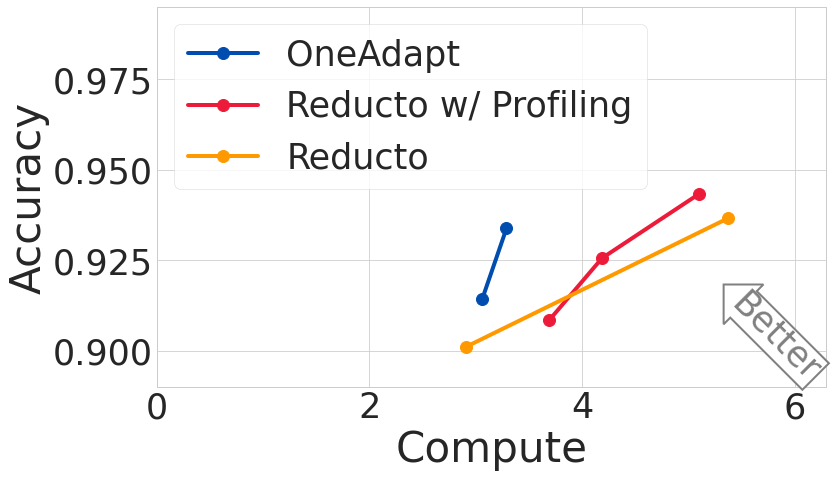

In [3]:


import numpy as np
# fmt = '/dataheart/dataset/rural/rural_1/part%d.mp4'
# v_list = [v_list[0]]

fig, ax = plt.subplots(figsize=(12, 7))

def make_plot(ax,d,c,l):
    delta = 0.73 if 'OneAdapt' in l else 0
    print([d[i].compute.mean() for i in d])
    ax.plot([d[i].compute.mean()+delta for i in d], [d[i].f1.mean() for i in d],c=c, marker='o', linewidth=4, markersize=12,label=l)
    

make_plot(ax, oneadapt, colors[0], 'OneAdapt')
make_plot(ax, profile, colors[1], 'Reducto w/ Profiling')
make_plot(ax, reducto, colors[2], 'Reducto')



# ax.plot([oneadapt_new[i].compute.mean() for i in [0.1,1.0,10]], [oneadapt_new[i].f1.mean() for i in [0.1,1.0,10]],c=colors[0], marker='o', linewidth=4, markersize=12)
# ax.plot([oneadapt[i].compute.mean() for i in [0.8,1.0,1.2]], [oneadapt[i].f1.mean() for i in [0.8,1.0,1.2]],c=colors[1], marker='o', linewidth=4, markersize=12)
# ax.set_xlim(left=0)

# ax.plot([oneadapt_new[i].bandwidth.mean() for i in oneadapt_new], [oneadapt_new[i].f1.mean() for i in oneadapt_new],c=colors[0], marker='o', linewidth=4, markersize=12)
# ax.plot([oneadapt[i].compute.mean() for i in [0.8,1.0,1.2]], [oneadapt[i].f1.mean() for i in [0.8,1.0,1.2]],c=colors[1], marker='o', linewidth=4, markersize=12)

ax.set_xlim(left=0)

l, r = 0, 6.3
b, u = 0.89, 0.995

ax.set_xlim(l,r)
ax.set_ylim(b,u)
ax.set_xlim(left=0)


ax.set_xlabel('Compute')
ax.set_ylabel('Accuracy')

bbox_props = dict(boxstyle="larrow", fc=(1,1,1), ec="grey", lw=2)
t = ax.text(r,b, "Better", ha="right", va="bottom", rotation=-45,
            bbox=bbox_props, c='grey')

bb = t.get_bbox_patch()
bb.set_boxstyle("larrow", pad=0.05)

ax.legend(loc=2,frameon=True)
    

In [23]:
savefig('/home/kuntai/paper/OneAdapt-SIGCOMM-23/figs/tradeoff-Reducto-compute-vs-acc', fig)

No handles with labels found to put in legend.


   second                                            input  bandwidth  \
0       0  /dataheart/dataset/country/country_0/part%d.mp4     101312   
1       1  /dataheart/dataset/country/country_0/part%d.mp4      88231   
2       2  /dataheart/dataset/country/country_0/part%d.mp4      84032   

   compute   f1  
0        1  1.0  
1        1  1.0  
2        1  1.0  
0    1.0
1    1.0
2    1.0
Name: f1, dtype: float64


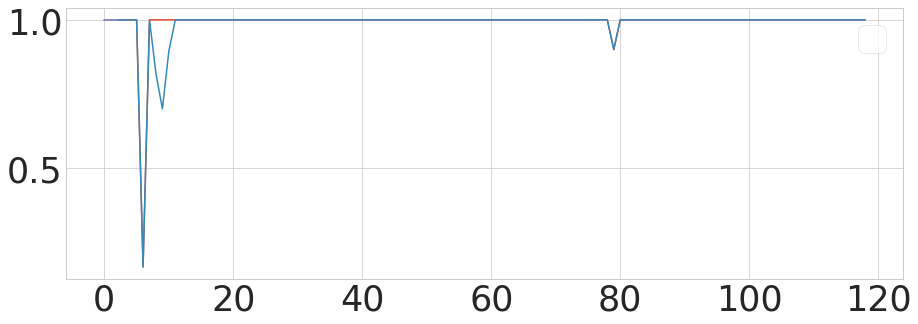

In [58]:

one = oneadapt[0.1][oneadapt[0.1].input == "/dataheart/dataset/country/country_0/part%d.mp4"].reset_index(drop=True)
prof = profile[0.07][profile[0.07].input == "/dataheart/dataset/country/country_0/part%d.mp4"].reset_index(drop=True)
red = reducto[-3][reducto[-3].input == "/dataheart/dataset/country/country_0/part%d.mp4"].reset_index(drop=True)

print(reducto[-3])
fig, ax = plt.subplots(figsize=(15, 5))
ax.plot(one.f1)
ax.plot(prof.f1)
ax.plot(red.f1)
print(red.f1)


# x = []

# for compute_weight in [0.8]:
#     approach = f'oneadapt_reducto_weight_{compute_weight}'
#     x = query_approach2(fmt, approach)
# print(np.mean([len(i['my_video_config']['encoded_frames']) for i in x]))
# ax.plot(range(len(x)), [i['f1'] for i in x], label='OneAdapt', c=colors[0], marker='s', linewidth=4, markersize=12)



# x = []
# for compute_weight in [ 0.04]:
#     for freq in [4]:
#         approach = f'reducto_weight_{compute_weight}_freq_{freq}'
#         x = query_approach2(fmt, approach)
# ax.plot(range(len(x)), [i['f1'] for i in x], label='Profiling', c=colors[1], marker='d', linewidth=4, markersize=12,alpha=0.8)
# print(np.mean([len(i['my_video_config']['encoded_frames']) for i in x]))

# with open(f'stats/country_2.f1s', 'r') as f:
#     f1s = yaml.load(f.read())
# # ax.plot(range(len(f1s)), f1s, label='No Adapt', c=colors[2], marker='o', linewidth=4, markersize=12, alpha=0.8)


# ax.axvline(x = 92, color = 'grey', linestyle='dashed', linewidth=4)
# ax.text(92,0.1, 'New car\nappears',horizontalalignment='left')
# ax.axvline(x = 113, color = 'grey', linestyle='dashed', linewidth=4)
# ax.text(112.5,0.55, 'New car\nappears',horizontalalignment='right')

# ax.set_xlim(90,118)
# ax.set_xlabel('Time (s)')
# ax.set_ylabel('Accuracy')

ax.legend(frameon=True)

In [15]:
savefig('/home/kuntai/paper/DiffAdapt-HotNets/figs/adaptation-RGB-reducto', fig)

In [16]:
x = [1.7647058823529411, 1.3781512605042017, 3.773109243697479, 3.495798319327731, 1.815126050420168]
y = [3.5210084033613445, 3.495798319327731, 5.092436974789916, 4.831932773109243, 3.6134453781512605]
print(np.mean(x))
print(np.mean(y))

2.4453781512605044
4.1109243697479
